In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import torch
import cv2
from tqdm import tqdm
from random import shuffle
from scipy.spatial import Delaunay
from gudhi import AlphaComplex
import gudhi as gd
import warnings
warnings.filterwarnings("ignore")

In [2]:
# open .pt image tensor
heatmaps = torch.load('data/anotated_MNIST/heatmaps/heatmaps_01.pt')
# open .pt label tensor
labels = torch.load('data/anotated_MNIST/raw/labels_01.pt')
# open .pt image tensor
images = torch.load('data/anotated_MNIST/raw/images_01.pt')
concepts = torch.load('data/anotated_MNIST/raw/concept_labels_01.pt')

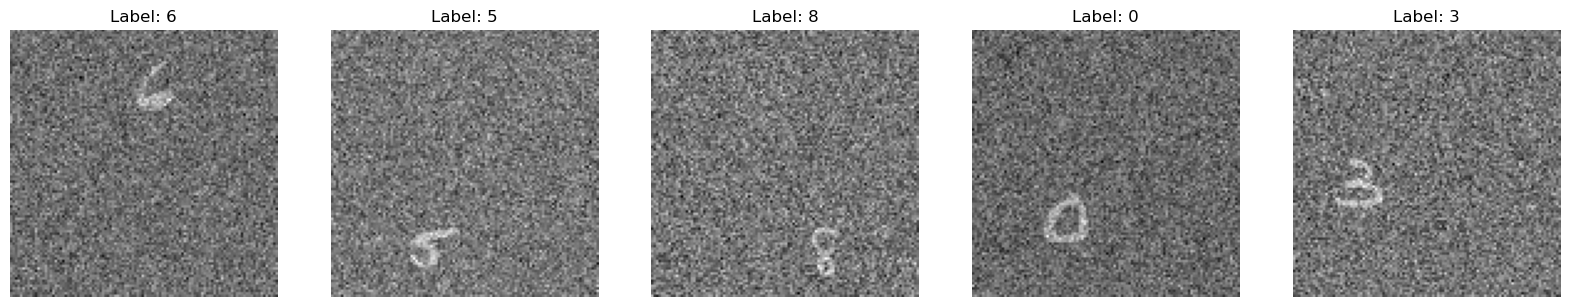

In [3]:
# plot 5 random original images
fig, ax = plt.subplots(1, 5, figsize=(20, 20))
for i, n in enumerate(range(15,20)):
    ax[i].imshow(images[n].numpy().reshape(108,108), cmap='gray')
    ax[i].set_title("Label: " + str(labels[n]))
    ax[i].axis('off')
plt.savefig('img/original_images.pdf')
plt.show()

# Processing of the data

In [4]:

cropped_images = []
bounding_boxes = []
for i in tqdm(range(len(heatmaps))):
    # find min and max x,y values of the heap that are not 0
    heat = heatmaps[i].squeeze().numpy()
    image = images[i].squeeze().numpy()

    for i in range(heat.shape[0]):
        if sum(heat[i]) > 100:
            min_x = i
            break
    for i in range(heat.shape[0]-1, 0, -1):
        if sum(heat[i]) > 100:
            max_x = i
            break
    for i in range(heat.shape[1]):
        if sum(heat[:,i]) > 100:
            min_y = i
            break
    for i in range(heat.shape[1]-1, 0, -1):
        if sum(heat[:,i]) > 100:
            max_y = i
            break

    bouding_box = (min_x, max_x, min_y, max_y)
    # crop image based on bounding box
    cropped_image = image[min_x:max_x, min_y:max_y]

    bounding_boxes.append(bouding_box)
    cropped_images.append(cropped_image)

# reshape to 40x40 images
cropped_images_reshaped = []
for i in range(len(cropped_images)):
    cropped_images_reshaped.append(cv2.resize(cropped_images[i], (40, 40)))
cropped_images_reshaped = np.array(cropped_images_reshaped)

100%|██████████| 300/300 [00:00<00:00, 749.49it/s]


# save cropped data

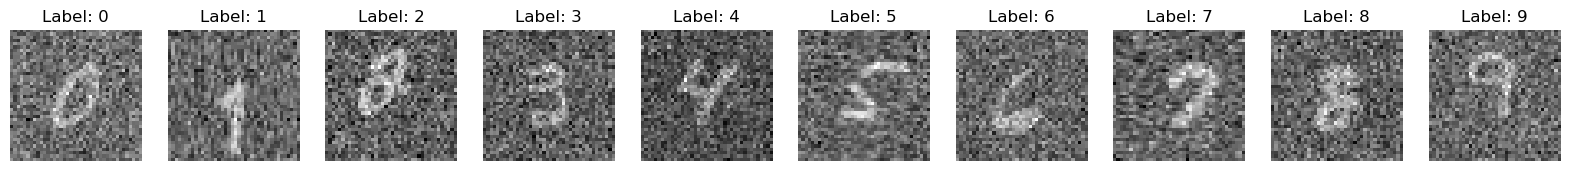

In [5]:
# sort images by labels index
sorted_images = []
sorted_labels = []
sorted_concepts = []

for i in range(10):
    for j in range(len(labels)):
        if labels[j] == i:
            sorted_images.append(cropped_images_reshaped[j])
            sorted_labels.append(labels[j])
            sorted_concepts.append(concepts[j])
plotting_images = sorted_images[4:]
plotting_labels = sorted_labels[4:]

# plot images
fig, ax = plt.subplots(1, 10, figsize=(20, 20))
counter = 0
for i in range(len(plotting_images)):
    if counter == plotting_labels[i]:
        ax[counter].imshow(plotting_images[i], cmap='gray')
        ax[counter].set_title("Label: " + str(plotting_labels[i]))
        ax[counter].axis('off')
        counter += 1
    if counter == 10:
        break
plt.savefig('img/cropped_images.pdf', dpi=300)
plt.show()

# Processing of the data

In [6]:
idx = 9

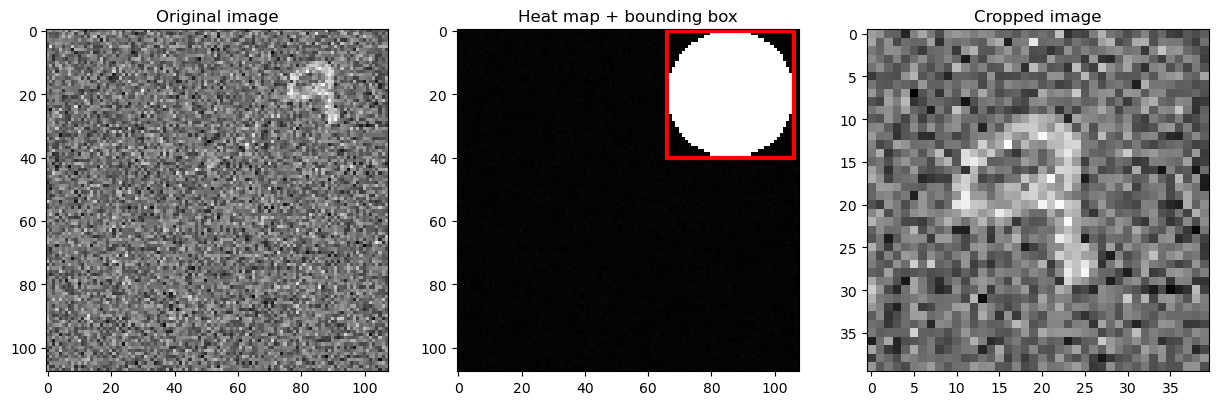

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(images[idx].squeeze(), cmap='gray')
axs[0].set_title("Original image")
axs[1].imshow(heatmaps[idx].squeeze(), cmap='gray')
axs[1].set_title("Heat map + bounding box")
(min_x, max_x, min_y, max_y) = bounding_boxes[idx]
axs[1].add_patch(plt.Rectangle((min_y, min_x), max_y-min_y, max_x-min_x, fill=False, edgecolor='red', lw=3))
axs[2].imshow(cropped_images[idx], cmap='gray')
axs[2].set_title("Cropped image")
plt.savefig('img/bounding_box.pdf', format="pdf")
plt.show()

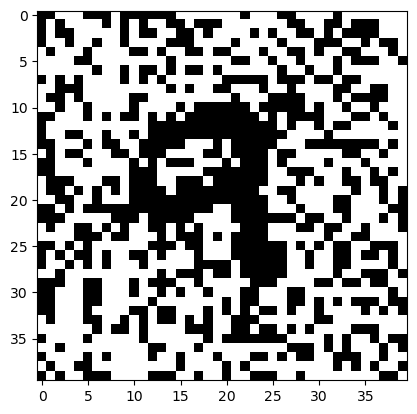

In [8]:

def convert_to_otsu(image):
    # perform otus thresholding
    # transform to torch tensor
    example = torch.from_numpy(image).float()

    # move minimum to 0 and maximum to 1
    example = example - example.min()
    example = example / example.max()
    # move between 0 and 255
    example = example * 255
    # convert to uint8
    example = example.type(torch.uint8)

    # perform otus thresholding
    ret, thresh = cv2.threshold(example.numpy().squeeze(), 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    return thresh

points = []
y = 0
example = convert_to_otsu(cropped_images_reshaped[idx])
# plot points
plt.imshow(example, cmap='gray')
plt.show()
for row in example:
    x = 0
    for el in row:
        if el == 0:
            points.append(np.array([x, y]))
        x += 1
    y += 1
points = np.array(points)



usetex mode requires TeX.


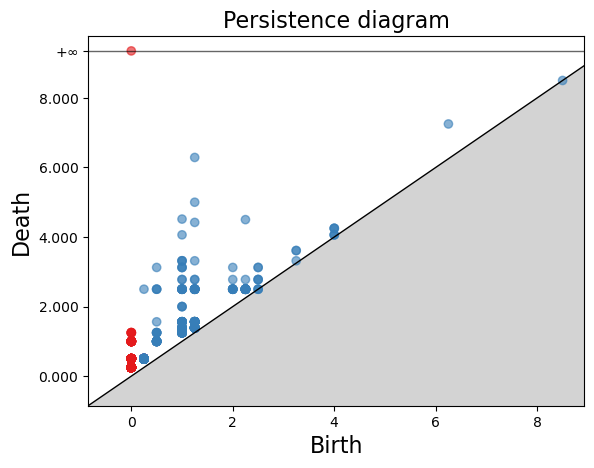

In [9]:
# calculate alpha complex
alpha_complex = AlphaComplex(points=points)
simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=1000)
# get persistence diagram
diag = simplex_tree.persistence()
# plot persistence diagram
gd.plot_persistence_diagram(diag)
# plt.savefig('img/persistence_diagram.pdf', format="pdf")
plt.show()

In [10]:
# transform cropped_images_reshaped between 0 and 255

for i in range(len(cropped_images_reshaped)):
    cropped_images_reshaped[i] = cropped_images_reshaped[i] - cropped_images_reshaped[i].min()
    cropped_images_reshaped[i] = cropped_images_reshaped[i] / cropped_images_reshaped[i].max()
    cropped_images_reshaped[i] = cropped_images_reshaped[i] * 255
    # conver numpy array to uint8
    cropped_images_reshaped[i] = cropped_images_reshaped[i].astype(np.uint8)

In [11]:
def transform_and_calculate_delunay(image, label, threshold=152):
    points = []
    y = 0
    for row in image:
        x = 0
        for el in row:
            points.append(np.array([[x, y], el]))
            x += 1
        y += 1
    # drop points with activation less than threshold
    points = np.array(points)
    points_cropped = points[points[:,1].astype(float) > threshold]
    points_cropped = np.array(list(map(lambda x: x, points_cropped[:,0])))
    # get distances from each point and is none of the points is closer than the treshold, then remove it
    new_points_cropped = []
    for i in range(len(points_cropped)):
        counter = 0
        for j in range(len(points_cropped)):
            if i != j:
                if np.linalg.norm(points_cropped[i] - points_cropped[j]) < 1.4:
                    if counter == 1:
                        new_points_cropped.append(points_cropped[i])
                        break
                    counter += 1
    tri = Delaunay(new_points_cropped, furthest_site=False)
    return new_points_cropped, tri

In [12]:
threshold = 152
data_for_plotting = []
for i in tqdm(range(len(cropped_images_reshaped))):
    example = cropped_images_reshaped[i]
    label = labels[i]
    new_points_cropped, tri = transform_and_calculate_delunay(example, label, threshold=152)
    data_for_plotting.append([example, label, new_points_cropped, tri])


100%|██████████| 300/300 [00:20<00:00, 14.76it/s]


In [13]:
example, label, new_points_cropped, tri = data_for_plotting[idx]

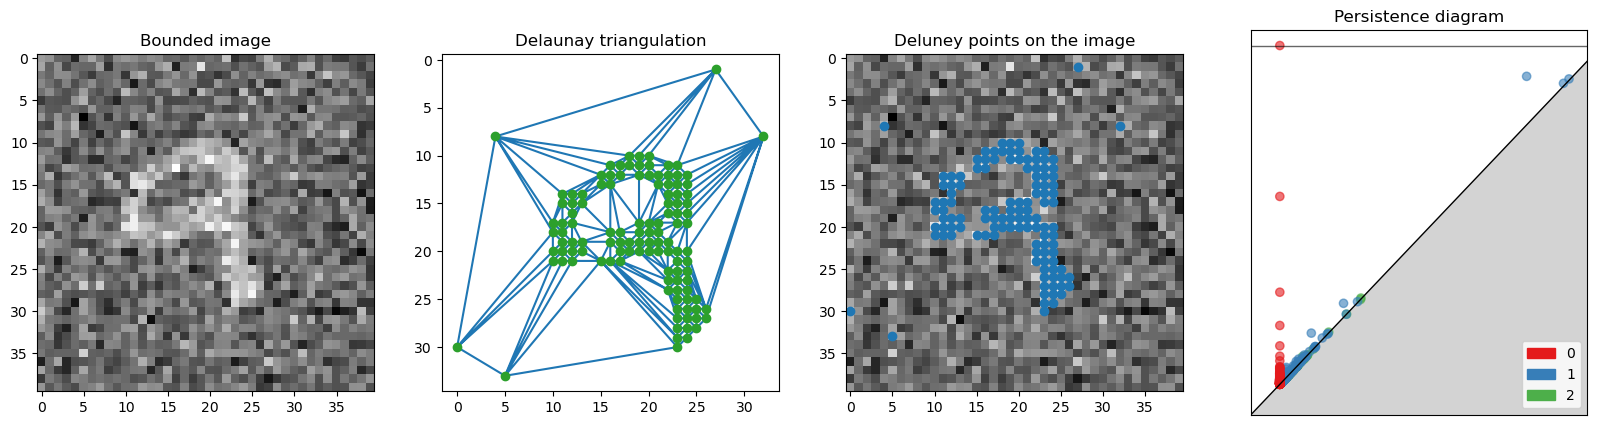

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(example, cmap='gray')
axs[0].set_title("Bounded image")
axs[1].triplot(list(map(lambda x: x[0], new_points_cropped)), list(map(lambda x: x[1], new_points_cropped)), tri.simplices.copy())
axs[1].plot(list(map(lambda x: x[0], new_points_cropped)), list(map(lambda x: x[1], new_points_cropped)), 'o')
axs[1].set_ylim(axs[1].get_ylim()[::-1])
axs[1].set_aspect('equal', 'box')
axs[1].set_title("Delaunay triangulation")
# plot only the points
axs[2].imshow(example, cmap='gray')
axs[2].plot(list(map(lambda x: x[0], new_points_cropped)), list(map(lambda x: x[1], new_points_cropped)), 'o')
axs[2].set_aspect('equal', 'box')
axs[2].set_title("Deluney points on the image")

ac = AlphaComplex(np.array(tri.simplices))
ac.create_simplex_tree()
st = ac.create_simplex_tree()
diagram1 = st.persistence()
gd.plot_persistence_diagram(diagram1, legend = True, axes=axs[3])
axs[3].set_title("Persistence diagram")
axs[3].get_yaxis().set_visible(False)
axs[3].get_xaxis().set_visible(False)

# plt.title("Persistence diagram for label {}".format(label))
# plt.savefig('img/persistence_diagram_example.pdf', format="pdf")

plt.savefig('img/delaunay.pdf', format="pdf")
plt.show()

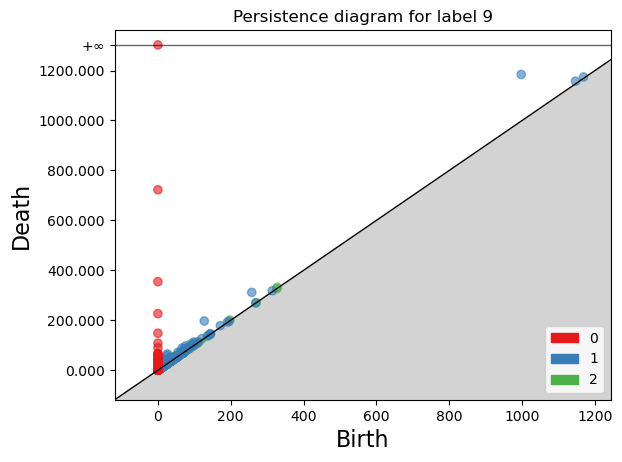

In [16]:
ac = AlphaComplex(np.array(tri.simplices))

ac.create_simplex_tree()

st = ac.create_simplex_tree()

diagram1 = st.persistence()

# plot the diagram
gd.plot_persistence_diagram(diagram1, legend = True)
plt.title("Persistence diagram for label {}".format(label))
plt.savefig('img/persistence_diagram_example.pdf', format="pdf")

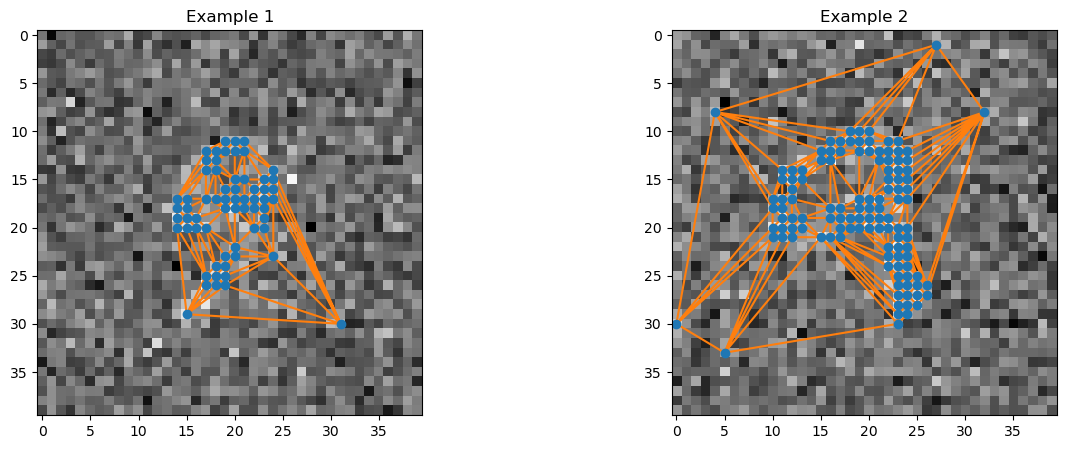

In [17]:
example1, label1, new_points_cropped1, tri1 = data_for_plotting[7]
example2, label2, new_points_cropped2, tri2 = data_for_plotting[9]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(example1, cmap='gray')
axs[0].plot(list(map(lambda x: x[0], new_points_cropped1)), list(map(lambda x: x[1], new_points_cropped1)), 'o')
axs[0].triplot(list(map(lambda x: x[0], new_points_cropped1)), list(map(lambda x: x[1], new_points_cropped1)), tri1.simplices.copy())
axs[0].set_title("Example 1")
axs[1].imshow(example2, cmap='gray')
axs[1].plot(list(map(lambda x: x[0], new_points_cropped2)), list(map(lambda x: x[1], new_points_cropped2)), 'o')
axs[1].triplot(list(map(lambda x: x[0], new_points_cropped2)), list(map(lambda x: x[1], new_points_cropped2)), tri2.simplices.copy())
axs[1].set_title("Example 2")

plt.show()

In [18]:
new_points_cropped1 = np.array(list(map(lambda x: x / 255, new_points_cropped1)))
new_points_cropped2 = np.array(list(map(lambda x: x / 255, new_points_cropped2)))
# normalize the tri 
tri1.simplices = np.array(list(map(lambda x: x / 255, tri1.simplices)))
tri2.simplices = np.array(list(map(lambda x: x / 255, tri2.simplices)))

In [32]:
example1, label1, new_points_cropped1, tri1 = data_for_plotting[7]
example2, label2, new_points_cropped2, tri2 = data_for_plotting[9]

ac1 = AlphaComplex(np.array(tri1.simplices))
ac2 = AlphaComplex(np.array(tri2.simplices))

ac1.create_simplex_tree()
ac2.create_simplex_tree()

st1 = ac1.create_simplex_tree()
st2 = ac2.create_simplex_tree()

diagram1 = st1.persistence()
diagram2 = st2.persistence()

# calculate blottleneck distance

bottleneck_distance = gd.bottleneck_distance(np.array(new_points_cropped1), np.array(new_points_cropped2))
print("Bottleneck distance between {} and {} is {}".format(label1, label2, bottleneck_distance))


Bottleneck distance between 9 and 9 is 14.0


<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

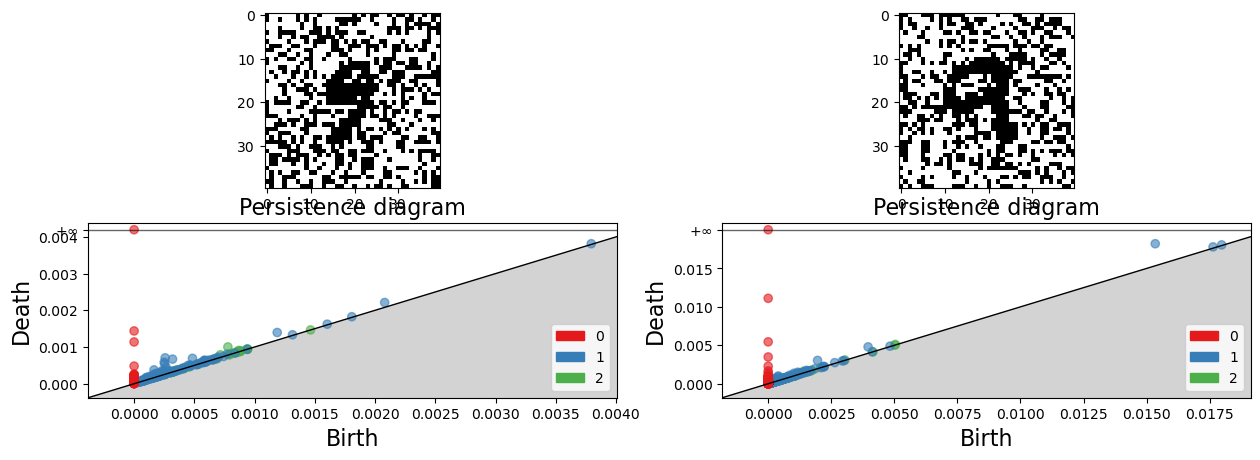

In [33]:
example1_otsu = convert_to_otsu(example1)
example2_otsu = convert_to_otsu(example2)
fig, axs = plt.subplots(2, 2, figsize=(15, 5))
# add padding to the image
axs[0][0].imshow(example1_otsu, cmap='gray')
gd.plot_persistence_diagram(diagram1, legend = True, axes=axs[1][0])
axs[0][1].imshow(example2_otsu, cmap='gray')
gd.plot_persistence_diagram(diagram2, legend = True, axes=axs[1][1])

# comparison perisstence diagrams imporant features

In [21]:
# improt original image
from utils import add_gausian_noise, pad_my_image
import torchvision
import numpy as np
import torch
import matplotlib.pyplot as plt
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train = torchvision.datasets.MNIST('data',train=True,download=True,transform=transform)

In [50]:
def TC_delunay(image, label, threshold=152):
    points = []
    y = 0
    for row in image:
        x = 0
        for el in row:
            points.append(np.array([[x, y], el]))
            x += 1
        y += 1
    # drop points with activation less than threshold
    points = np.array(points)
    points_cropped = points[points[:,1].astype(float) > threshold]
    points_cropped = np.array(list(map(lambda x: x, points_cropped[:,0])))
    # get distances from each point and is none of the points is closer than the treshold, then remove it
    new_points_cropped = []
    for i in range(len(points_cropped)):
        counter = 0
        for j in range(len(points_cropped)):
            if i != j:
                if np.linalg.norm(points_cropped[i] - points_cropped[j]) < 1.4:
                    if counter == 1:
                        new_points_cropped.append(points_cropped[i])
                        break
                    counter += 1
    # print(np.array(points[:,0]))
    # print(new_points_cropped)
    # tri = Delaunay(np.array(list(map(lambda x: x, points[:,0]))), furthest_site=False)
    tri = Delaunay(np.array(new_points_cropped), furthest_site=False)
    return new_points_cropped, tri

In [56]:
def transform_to_255(noisy_image, image_clean):
    # transform cropped_images_reshaped between 0 and 255
    noisy_image = noisy_image.numpy()
    noisy_image = noisy_image - noisy_image.min()
    noisy_image = noisy_image / noisy_image.max()
    noisy_image = noisy_image * 255
    # conver numpy array to uint8
    noisy_image = noisy_image.astype(np.uint8)

    image_clean = image_clean.numpy()
    image_clean = image_clean - image_clean.min()
    image_clean = image_clean / image_clean.max()
    image_clean = image_clean * 255
    # conver numpy array to uint8
    image_clean = image_clean.astype(np.uint8)
    return noisy_image, image_clean

In [57]:
def get_diagrams(noisy_image, clean_image, label):
    # calculate persistence diagram for the noisy image
    _, tri = TC_delunay(noisy_image, label, threshold=152)
    ac = AlphaComplex(np.array(tri.simplices))
    ac.create_simplex_tree()
    st = ac.create_simplex_tree()
    diagram1 = st.persistence()

    # calculate persistence diagram for the clean image
    new_points_cropped, tri = TC_delunay(clean_image, label, threshold=152)
    ac = AlphaComplex(np.array(tri.simplices))
    ac.create_simplex_tree()
    st = ac.create_simplex_tree()
    diagram2 = st.persistence()
    return diagram1, diagram2

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

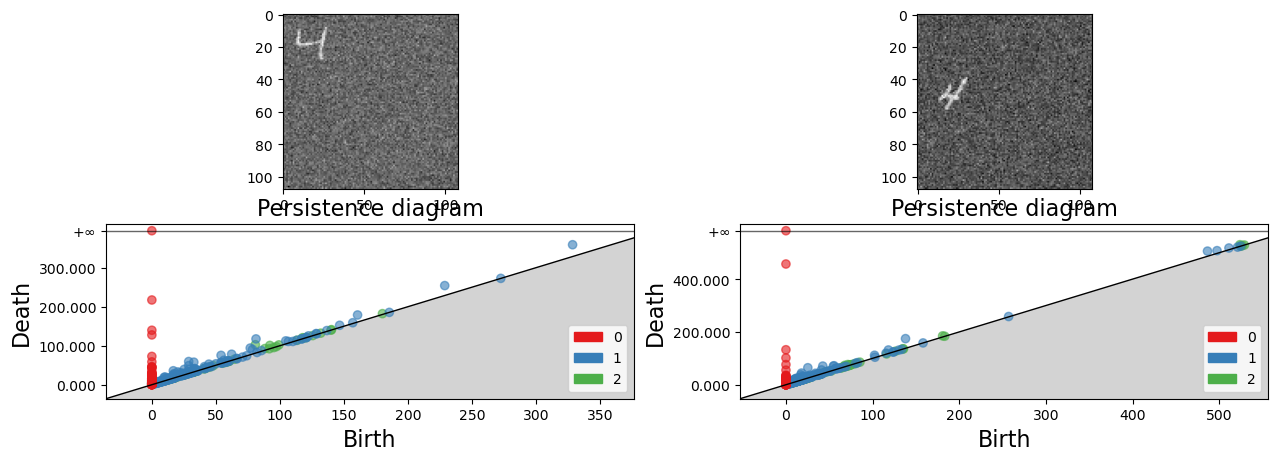

In [87]:
image1 = train[2][0]
image2 = train[9][0]

# add padding to the image
image_clean1 = pad_my_image(image1.reshape(28, 28))
noisy_image1 = add_gausian_noise(image_clean1)

image_clean2 = pad_my_image(image2.reshape(28, 28))
noisy_image2 = add_gausian_noise(image_clean2)

# transform to 255
noisy_image1, image_clean1 = transform_to_255(noisy_image1, image_clean1)
noisy_image2, image_clean2 = transform_to_255(noisy_image2, image_clean2)

diagram1_noisy, diagram2 = get_diagrams(noisy_image1, image_clean1, 1)
diagram3_noisy, diagram4 = get_diagrams(noisy_image2, image_clean2, 2)

fig, axs = plt.subplots(2, 2, figsize=(15, 5))
# add padding to the image
axs[0][0].imshow(noisy_image1, cmap='gray')
gd.plot_persistence_diagram(diagram1_noisy, legend = True, axes=axs[1][0])
axs[0][1].imshow(noisy_image2, cmap='gray')
gd.plot_persistence_diagram(diagram3_noisy, legend = True, axes=axs[1][1])

# Evaluation

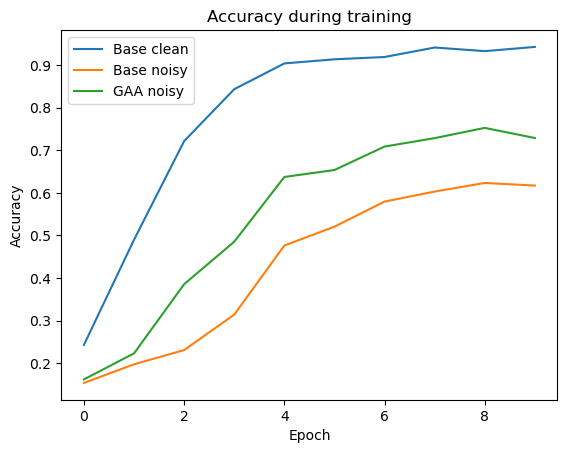

In [76]:
base_path = "/Users/blazdobravec/Documents/FACULTY/DOC/RW1/PERSONAL/attention_concept/accs_base_03_1494%.pt"
noise_path = "/Users/blazdobravec/Documents/FACULTY/DOC/RW1/PERSONAL/attention_concept/accs_noise_04_13_61%.pt"
persistence_prototype_path = "/Users/blazdobravec/Documents/FACULTY/DOC/RW1/PERSONAL/attention_concept/accs_proto_03_17.pt"
base = torch.load(base_path)
noise = torch.load(noise_path)
persistence_prototype = torch.load(persistence_prototype_path)

# plot on the same graph
plt.plot(np.array(list(map(lambda x: x.to("cpu").squeeze().numpy(), base))), label="Base clean")
plt.plot(np.array(list(map(lambda x: x.to("cpu").squeeze().numpy(), noise))), label="Base noisy")
plt.plot(np.array(list(map(lambda x: x.to("cpu").squeeze().numpy(), persistence_prototype))), label="GAA noisy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy during training")
plt.savefig('img/accs_base.pdf', format="pdf")
plt.show()


# Comparing to prototypes

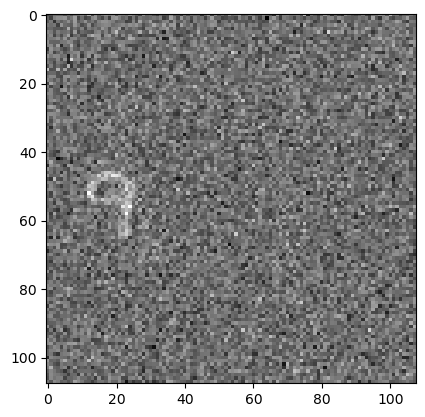

In [103]:
# plt.imshow(cropped_images_reshaped[3], cmap='gray')
plt.imshow(images[3].reshape(108, 108), cmap='gray')

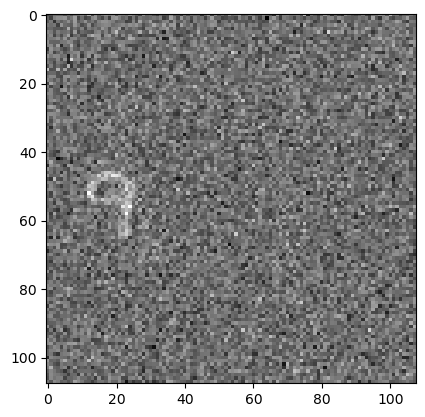

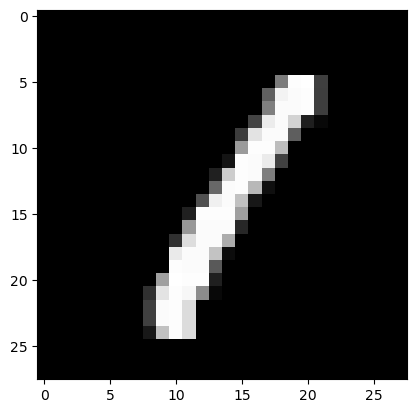

In [112]:
image1 = train[3][0]
image2 = train[9][0]

plt.imshow(images[3].reshape(108, 108), cmap='gray')
plt.show()
plt.imshow(image1.reshape(28, 28), cmap='gray')
# # add padding to the image
# image_clean1 = pad_my_image(image1.reshape(28, 28))
# noisy_image1 = add_gausian_noise(image_clean1)

# image_clean2 = pad_my_image(image2.reshape(28, 28))
# noisy_image2 = add_gausian_noise(image_clean2)

# # transform to 255
# noisy_image1, image_clean1 = transform_to_255(noisy_image1, image_clean1)
# noisy_image2, image_clean2 = transform_to_255(noisy_image2, image_clean2)

# diagram1_noisy, diagram2 = get_diagrams(noisy_image1, image_clean1, 1)
# diagram3_noisy, diagram4 = get_diagrams(noisy_image2, image_clean2, 2)